## Predicive Modelling

### Loading Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import itertools
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

### Time Frame of Different Data Files

1. SP500 - 2007 - 2022
2. Unemployment Rate - 2007 - 2024
3. Inflation Data - 2005 - 2024
4. Heart Disease Data - 2007 - 2022

### Loading Data

In [2]:
file_paths = {
    "sp500": "SP500_2007_2022.csv",
    "unemployment": "US_monthly_unemployment_rate_from_2007to2024.csv",
    "inflation": "US_monthly_inflation_rate_from_2005to2024.csv",
    "heart_disease": "merged_df_heart_attack_2007to2022.csv"
}

sp500_data = pd.read_csv(file_paths["sp500"])
unemployment_data = pd.read_csv(file_paths["unemployment"])
inflation_data = pd.read_csv(file_paths["inflation"])
heart_disease_data = pd.read_csv(file_paths["heart_disease"])



In [3]:
heart_disease_data['Year'].unique()

array([2007, 2008, 2009, 2011, 2010, 2012, 2013, 2015, 2014, 2017, 2016,
       2018, 2019, 2020, 2021, 2022])

In [4]:
# Display column names for verification
print("SP500 Data Columns:", sp500_data.columns)
print("Unemployment Data Columns:", unemployment_data.columns)
print("Inflation Data Columns:", inflation_data.columns)
print("Heart Disease Data Columns:", heart_disease_data.columns)

SP500 Data Columns: Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
Unemployment Data Columns: Index(['DATE', 'UNEMPLOY_RATE'], dtype='object')
Inflation Data Columns: Index(['Date', 'Inflation_rate', 'Unnamed: 2'], dtype='object')
Heart Disease Data Columns: Index(['Notes', 'Five-Year Age Groups', 'Five-Year Age Groups Code', 'State',
       'State Code', 'Month', 'Month Code', 'Cause of death',
       'Cause of death Code', 'Deaths', 'Population', 'Crude Rate',
       'Month_Name', 'Year'],
      dtype='object')


### Cleaning Data

* We'll standardize the column names for all the datasets for better interpretability

In [5]:
# Function to standardize column names
def standardize_columns(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('.', '', regex=False)
    return df

# Standardize column names for all datasets
sp500_data = standardize_columns(sp500_data)
unemployment_data = standardize_columns(unemployment_data)
inflation_data = standardize_columns(inflation_data)
heart_disease_data = standardize_columns(heart_disease_data)

# Display standardized column names for verification
print("SP500 Data Columns:", sp500_data.columns)
print("Unemployment Data Columns:", unemployment_data.columns)
print("Inflation Data Columns:", inflation_data.columns)
print("Heart Disease Data Columns:", heart_disease_data.columns)


SP500 Data Columns: Index(['date', 'adj_close', 'close', 'high', 'low', 'open', 'volume'], dtype='object')
Unemployment Data Columns: Index(['date', 'unemploy_rate'], dtype='object')
Inflation Data Columns: Index(['date', 'inflation_rate', 'unnamed:_2'], dtype='object')
Heart Disease Data Columns: Index(['notes', 'five_year_age_groups', 'five_year_age_groups_code', 'state',
       'state_code', 'month', 'month_code', 'cause_of_death',
       'cause_of_death_code', 'deaths', 'population', 'crude_rate',
       'month_name', 'year'],
      dtype='object')


In [6]:
inflation_data.drop(['unnamed:_2'], axis=1, inplace=True)

* Checking Data type of columns in `heart_disease_data`

In [7]:
heart_disease_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70913 entries, 0 to 70912
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   notes                      0 non-null      float64
 1   five_year_age_groups       70913 non-null  object 
 2   five_year_age_groups_code  70913 non-null  object 
 3   state                      70913 non-null  object 
 4   state_code                 70913 non-null  float64
 5   month                      70913 non-null  object 
 6   month_code                 70913 non-null  object 
 7   cause_of_death             70913 non-null  object 
 8   cause_of_death_code        70913 non-null  object 
 9   deaths                     70913 non-null  float64
 10  population                 70913 non-null  object 
 11  crude_rate                 70913 non-null  object 
 12  month_name                 70913 non-null  object 
 13  year                       70913 non-null  int

* Converting `year` and `month_Name` to appropriate format and creating a new variable `date` by combining these two columns. 
* We'll remove irrelevant columns such as `five_year_age_groups_code`, `month_code`, `cause_of_death`, `population`, `crude_rate`.

In [8]:
heart_disease_data['month_name'].unique()

array(['Mar.', 'Nov.', 'Jan.', 'Feb.', 'Apr.', 'May', 'Jun.', 'Jul.',
       'Aug.', 'Sep.', 'Oct.', 'Dec.'], dtype=object)

* The month name `May` has some inconsistencies. It misses the '.' . Let's fix this!

In [9]:
# Add a period to 'May' to ensure consistency
heart_disease_data['month_name'] = heart_disease_data['month_name'].str.replace(r'^May$', 'May.', regex=True)

* May has been rectified

In [10]:
# Combine 'month_name' and 'year' into a 'date' column
heart_disease_data['date'] = pd.to_datetime(heart_disease_data['month_name'] + ' ' + heart_disease_data['year'].astype(str), format='%b. %Y', errors='coerce')

heart_disease_data.drop(['five_year_age_groups_code','month_code', 'cause_of_death', 'population', 'crude_rate','notes'], axis=1, inplace=True)


* Perfect!

### Checking if we have the relevant ICD-10 Codes

* Codes `I00-I99` - Diseases related to circulatory systems (“2025 ICD-10-CM Codes I00-I99: Diseases of the Circulatory System,” n.d.)

In [11]:
heart_disease_data['cause_of_death_code'].unique()


array(['I11.9', 'I25.1', 'I21.9', 'I42.9', 'I25.0', 'I61.9', 'I51.7',
       'I64', 'I60.9', 'I62.9', 'I42.0', 'I46.9', 'I50.0', 'I10', 'I12.0',
       'I71.0', 'I11.0', 'I25.9', 'I69.4', 'I25.5', 'I48', 'I69.8',
       'I26.9', 'I35.0', 'I70.9', 'I51.6', 'I71.3', 'I38', 'I73.9',
       'I67.9', 'I49.9', 'I50.9', 'I51.9', 'I63.9', 'I34.0', 'I67.2',
       'I62.0', 'I80.2', 'I27.2', 'I13.2', 'I25.8', 'I67.8', 'I21.4',
       'I69.3', 'I13.1', 'I63.4'], dtype=object)

In [12]:
heart_disease_data['cause_of_death_code'].nunique()


46

* We'll remove `I62` and `I62.9` since they are not related to the scope of the project.

In [13]:
# Remove rows where 'cause_of_death_code' is either 'I62' or 'I62.9'
heart_disease_data = heart_disease_data[~heart_disease_data['cause_of_death_code'].isin(['I62.0', 'I62.9'])]

# Verify the result
print(heart_disease_data['cause_of_death_code'].unique())

['I11.9' 'I25.1' 'I21.9' 'I42.9' 'I25.0' 'I61.9' 'I51.7' 'I64' 'I60.9'
 'I42.0' 'I46.9' 'I50.0' 'I10' 'I12.0' 'I71.0' 'I11.0' 'I25.9' 'I69.4'
 'I25.5' 'I48' 'I69.8' 'I26.9' 'I35.0' 'I70.9' 'I51.6' 'I71.3' 'I38'
 'I73.9' 'I67.9' 'I49.9' 'I50.9' 'I51.9' 'I63.9' 'I34.0' 'I67.2' 'I80.2'
 'I27.2' 'I13.2' 'I25.8' 'I67.8' 'I21.4' 'I69.3' 'I13.1' 'I63.4']


In [14]:
heart_disease_data['cause_of_death_code'].nunique()

44

* We've successfully removed the irrelevant columns.

## Checking if there are null values

In [15]:
# Function to check for null values
def check_null_values(df, dataset_name):
    null_counts = df.isnull().sum()
    print(f"Null values in {dataset_name}:")
    print(null_counts[null_counts > 0])  # Display columns with null values
    print('-' * 40)

# Check for null values in each dataset
check_null_values(sp500_data, "SP500 Data")
check_null_values(unemployment_data, "Unemployment Data")
check_null_values(inflation_data, "Inflation Data")
check_null_values(heart_disease_data, "Heart Disease Data")


Null values in SP500 Data:
Series([], dtype: int64)
----------------------------------------
Null values in Unemployment Data:
Series([], dtype: int64)
----------------------------------------
Null values in Inflation Data:
Series([], dtype: int64)
----------------------------------------
Null values in Heart Disease Data:
Series([], dtype: int64)
----------------------------------------


* Therefore, we don't have null values in any of our datasets.

### Removing irrelevant columns from SP500

In [16]:
sp500_data.drop(['close','high','low','open','volume'], axis=1, inplace=True)

In [17]:
sp500_data.head()

,date,adj_close
0,2007-01-03 00:00:00+00:00,1416.599976
1,2007-01-04 00:00:00+00:00,1418.339966
2,2007-01-05 00:00:00+00:00,1409.709961
3,2007-01-08 00:00:00+00:00,1412.839966
4,2007-01-09 00:00:00+00:00,1412.109985


## Now we need to ensure each dataset has the correct `date` column.

#### 1. Inflation Data

In [18]:
inflation_data['date'] = pd.to_datetime(inflation_data['date'], format='%b-%y')


In [19]:
inflation_data['date'].isnull().sum()

0

* This data is ready to use. `date` column has been transformed to datetime and no null values are found

#### 2. Unemployment Data

In [20]:
unemployment_data['date'] = pd.to_datetime(unemployment_data['date'])

In [21]:
inflation_data['date'].isnull().sum()

0

In [22]:
unemployment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           214 non-null    datetime64[ns]
 1   unemploy_rate  214 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.5 KB


* This data is ready to use. `date` column has been transformed to datetime and no null values are found

#### 3. SP500 Data

In [23]:
sp500_data['date'] = pd.to_datetime(sp500_data['date']).dt.tz_localize(None)
sp500_data.set_index('date', inplace=True)

# Resample to monthly frequency and calculate the average of 'adj_close'
sp500_data_monthly = sp500_data.resample('MS').mean()

# Reset the index to bring 'date' back as a column
sp500_data_monthly.reset_index(inplace=True)

# Display the resulting DataFrame
print(sp500_data_monthly.tail())


          date    adj_close
187 2022-08-01  4158.563084
188 2022-09-01  3850.520496
189 2022-10-01  3726.050956
190 2022-11-01  3917.488595
191 2022-12-01  3912.380952


In [24]:
sp500_data_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       192 non-null    datetime64[ns]
 1   adj_close  192 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.1 KB


* This data is ready to use. `date` column has been transformed to datetime and no null values are found

#### 4. Heart Disease Data

In [25]:
heart_disease_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70061 entries, 0 to 70912
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   five_year_age_groups  70061 non-null  object        
 1   state                 70061 non-null  object        
 2   state_code            70061 non-null  float64       
 3   month                 70061 non-null  object        
 4   cause_of_death_code   70061 non-null  object        
 5   deaths                70061 non-null  float64       
 6   month_name            70061 non-null  object        
 7   year                  70061 non-null  int64         
 8   date                  70061 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 5.3+ MB


* This data is ready to use. `date` column has been transformed to datetime and no null values are found

In [26]:
heart_disease_data['deaths_diff'] = heart_disease_data['deaths'].diff().dropna()

### Now Creating our Target Variable and Refining heart_disesase_data

* We'll create target variable `Death_Counts`.

In [27]:
# Group by 'date' and sum deaths directly
heart_disease_summary = heart_disease_data.groupby('date', as_index=False)['deaths'].sum()

# Rename column for clarity
heart_disease_summary.rename(columns={'deaths': 'death_counts'}, inplace=True)

# Display the result
heart_disease_summary.head()


,date,death_counts
0,2007-01-01,15383.0
1,2007-02-01,13472.0
2,2007-03-01,14440.0
3,2007-04-01,13148.0
4,2007-05-01,12956.0


In [28]:
sp500_data_monthly

,date,adj_close
0,2007-01-01,1424.160986
1,2007-02-01,1444.794748
2,2007-03-01,1406.951821
3,2007-04-01,1463.640503
4,2007-05-01,1511.136813
...,...,...
187,2022-08-01,4158.563084
188,2022-09-01,3850.520496
189,2022-10-01,3726.050956
190,2022-11-01,3917.488595


## Joining all 4 dataframes to have a master dataframe

In [29]:
# Step 1: Merge heart_disease_summary with sp500_data
merged_data = pd.merge(
    heart_disease_summary,
    sp500_data_monthly,
    on='date',
    how='inner'
)

In [30]:
# Step 2: Merge with inflation_data
merged_data = pd.merge(
    merged_data,
    inflation_data,
    on='date',
    how='inner'
)

In [31]:
# Step 3: Merge with unemployment_data
merged_data = pd.merge(
    merged_data,
    unemployment_data,
    on='date',
    how='inner'
)

# Step 4: Check the final range and structure
print("Final Data Range:", merged_data['date'].min(), "to", merged_data['date'].max())
print(merged_data.info())


Final Data Range: 2007-01-01 00:00:00 to 2022-12-01 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            192 non-null    datetime64[ns]
 1   death_counts    192 non-null    float64       
 2   adj_close       192 non-null    float64       
 3   inflation_rate  192 non-null    float64       
 4   unemploy_rate   192 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 7.6 KB
None


After combining all four datasets (deaths due to heartattack, sp500, unemployment rate, inflation rate), total entries are 192 which is consistent. 

In [32]:
merged_data.head()

,date,death_counts,adj_close,inflation_rate,unemploy_rate
0,2007-01-01,15383.0,1424.160986,2.08,4.1
1,2007-02-01,13472.0,1444.794748,2.42,4.0
2,2007-03-01,14440.0,1406.951821,2.78,3.9
3,2007-04-01,13148.0,1463.640503,2.57,3.9
4,2007-05-01,12956.0,1511.136813,2.69,3.9


## Check for Multicollinearity

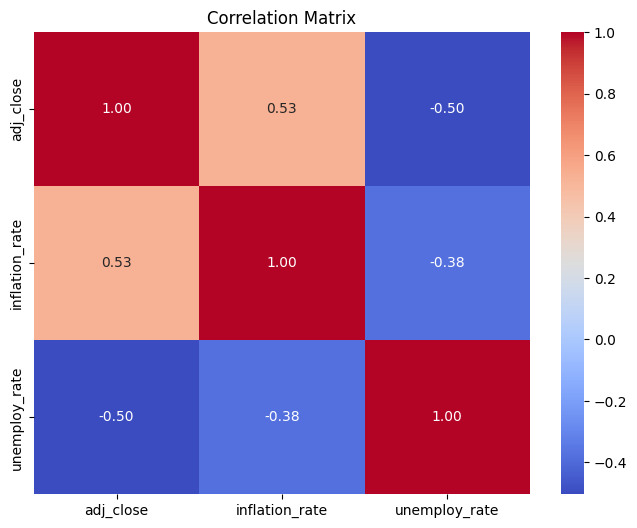

In [33]:
# Compute correlation matrix
correlation_matrix = merged_data[['adj_close', 'inflation_rate', 'unemploy_rate']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


No significant multicollinearity is evident based on the correlation matrix. It is safe to include all three variables (adj_close, inflation_rate, and unemploy_rate) in the predictive model for Death_Counts.


# Analysis

In [34]:
merged_data = merged_data.sort_values(by='date')

In [35]:
# Creating lag variables 
merged_data['lag_deaths'] = merged_data['death_counts'].shift(1)
merged_data['lag_unemployment'] = merged_data['unemploy_rate'].shift(1)
merged_data['lag_inflation'] = merged_data['inflation_rate'].shift(1)


In [36]:
# Rolling Averages
merged_data['rolling_deaths'] = merged_data['death_counts'].rolling(window=3).mean()

In [37]:
merged_data = merged_data.dropna()


## Feature Engineering
Adding seasonality features to capture the monthly pattern:

In [38]:
# Add Month as a Feature
merged_data['month'] = merged_data['date'].dt.month

# Add Cyclical Features for Month
merged_data['month_sin'] = np.sin(2 * np.pi * merged_data['month'] / 12)
merged_data['month_cos'] = np.cos(2 * np.pi * merged_data['month'] / 12)


In [39]:
merged_data.head()

,date,death_counts,adj_close,inflation_rate,unemploy_rate,lag_deaths,lag_unemployment,lag_inflation,rolling_deaths,month,month_sin,month_cos
2,2007-03-01,14440.0,1406.951821,2.78,3.9,13472.0,4.0,2.42,14431.666667,3,1.000000e+00,6.123234e-17
3,2007-04-01,13148.0,1463.640503,2.57,3.9,14440.0,3.9,2.78,13686.666667,4,8.660254e-01,-5.000000e-01
4,2007-05-01,12956.0,1511.136813,2.69,3.9,13148.0,3.9,2.57,13514.666667,5,5.000000e-01,-8.660254e-01
5,2007-06-01,12001.0,1514.489519,2.69,4.0,12956.0,3.9,2.69,12701.666667,6,1.224647e-16,-1.000000e+00
6,2007-07-01,11959.0,1520.704758,2.36,4.2,12001.0,4.0,2.69,12305.333333,7,-5.000000e-01,-8.660254e-01


## Train-Test Split
Use a time-based split to avoid data leakage:

In [40]:
# Split into train and test datasets
train_data = merged_data[merged_data['date'] < '2020-01-01']
test_data = merged_data[merged_data['date'] >= '2020-01-01']

# Define Features and Target
features = ['adj_close', 'inflation_rate', 'unemploy_rate', 'lag_deaths', 'lag_inflation', 'lag_unemployment', 'month_sin', 'month_cos', 'rolling_deaths']
X_train = train_data[features]
y_train = train_data['death_counts']
X_test = test_data[features]
y_test = test_data['death_counts']


In [41]:
merged_data.set_index('date', inplace=True)
print(merged_data.index)

DatetimeIndex(['2007-03-01', '2007-04-01', '2007-05-01', '2007-06-01',
               '2007-07-01', '2007-08-01', '2007-09-01', '2007-10-01',
               '2007-11-01', '2007-12-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='date', length=190, freq=None)


## Modeling Approaches


# 1: Time-Series with SARIMAX
SARIMAX allows the inclusion of exogenous variables like inflation_rate and unemploy_rate:

In [42]:

# Define p, d, q and seasonal (P, D, Q, S) ranges
p = d = q = range(0, 3)
seasonal_p = seasonal_d = seasonal_q = range(0, 2)
seasonal_s = [12]  # Monthly seasonality

# Generate combinations
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(seasonal_p, seasonal_d, seasonal_q, seasonal_s))

best_aic = float("inf")
best_order = None
best_seasonal_order = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(merged_data['death_counts'],
                            exog=merged_data[['inflation_rate', 'unemploy_rate']],
                            order=param,
                            seasonal_order=param_seasonal)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
        except:
            continue

print(f"Best SARIMAX order: {best_order}")
print(f"Best Seasonal order: {best_seasonal_order}")



Best SARIMAX order: (2, 1, 1)
Best Seasonal order: (0, 1, 1, 12)


In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
merged_data[['inflation_rate', 'unemploy_rate']] = scaler.fit_transform(merged_data[['inflation_rate', 'unemploy_rate']])


In [44]:
# Re-fit the SARIMAX model with tuned parameters
model = SARIMAX(train_data['death_counts'],
                exog=train_data[['inflation_rate', 'unemploy_rate']],
                order=best_order,
                seasonal_order=best_seasonal_order)
results = model.fit()

# Forecast for the test set
forecast = results.get_forecast(steps=len(test_data), exog=test_data[['inflation_rate', 'unemploy_rate']])
forecast_mean = forecast.predicted_mean

# Evaluate
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_data['death_counts'], forecast_mean)
print(f'MSE: {mse:.2f}')


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.90578D+00    |proj g|=  5.58852D-02

At iterate    5    f=  6.88429D+00    |proj g|=  6.79305D-02

At iterate   10    f=  6.87543D+00    |proj g|=  1.23820D-03

At iterate   15    f=  6.87485D+00    |proj g|=  8.69717D-04


 This problem is unconstrained.



At iterate   20    f=  6.87226D+00    |proj g|=  3.41995D-02

At iterate   25    f=  6.82645D+00    |proj g|=  5.44198D-02

At iterate   30    f=  6.77253D+00    |proj g|=  9.85932D-03

At iterate   35    f=  6.77245D+00    |proj g|=  8.44435D-04

At iterate   40    f=  6.77242D+00    |proj g|=  1.92268D-03

At iterate   45    f=  6.77219D+00    |proj g|=  4.07314D-03

At iterate   50    f=  6.76608D+00    |proj g|=  1.23502D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   1.235D-02   6.766D+00
  F =   6.7660780807144958     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

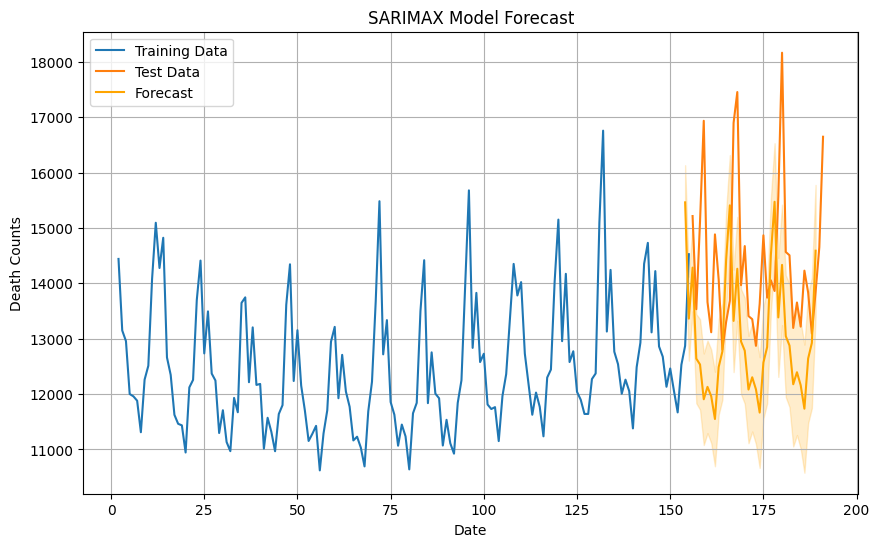

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['death_counts'], label='Training Data')
plt.plot(test_data.index, test_data['death_counts'], label='Test Data')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='orange')
plt.fill_between(forecast_mean.index, 
                 forecast.conf_int().iloc[:, 0], 
                 forecast.conf_int().iloc[:, 1], 
                 color='orange', alpha=0.2)
plt.legend()
plt.title('SARIMAX Model Forecast')
plt.xlabel('Date')
plt.ylabel('Death Counts')
plt.grid(True)
plt.show()



In [46]:
# Calculating MAE
mse = mean_squared_error(test_data['death_counts'], forecast_mean)
mae = mean_absolute_error(test_data['death_counts'], forecast_mean)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 2619273.033454497
Mean Absolute Error (MAE): 1353.267404206283


In [47]:
mean_death_counts = test_data['death_counts'].mean()
percentage_error = (mae / mean_death_counts) * 100
print(f'MAE Percentage Error: {percentage_error:.2f}%')


MAE Percentage Error: 9.40%


MAE < 10% of the mean of the target variable is generally considered good.
For forecasting tasks (like predicting deaths), error metrics such as MAE and MSE are generally more important because they directly quantify the prediction error.

In [48]:
# Calculate R² score
r2 = r2_score(test_data['death_counts'], forecast_mean)
print(f'R² Score: {r2:.4f}')


R² Score: -0.4849


Conclusion: 
For forecasting problems, MAE is sufficient to evaluate the model's performance and make decisions.
R2 is used as a secondary metric if you want to compare models or explain variance for stakeholders.


# 2: Machine Learning
Use Random Forest or Gradient Boosting models for supervised learning:

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R²: {r2:.4f}')



MSE: 1102988.18
MAE: 780.68
R²: 0.3747


In [50]:
percentage_error = (mae/ mean_death_counts) * 100
print(f'MAE Percentage Error: {percentage_error:.2f}%')

MAE Percentage Error: 5.42%


# Comparing both Models

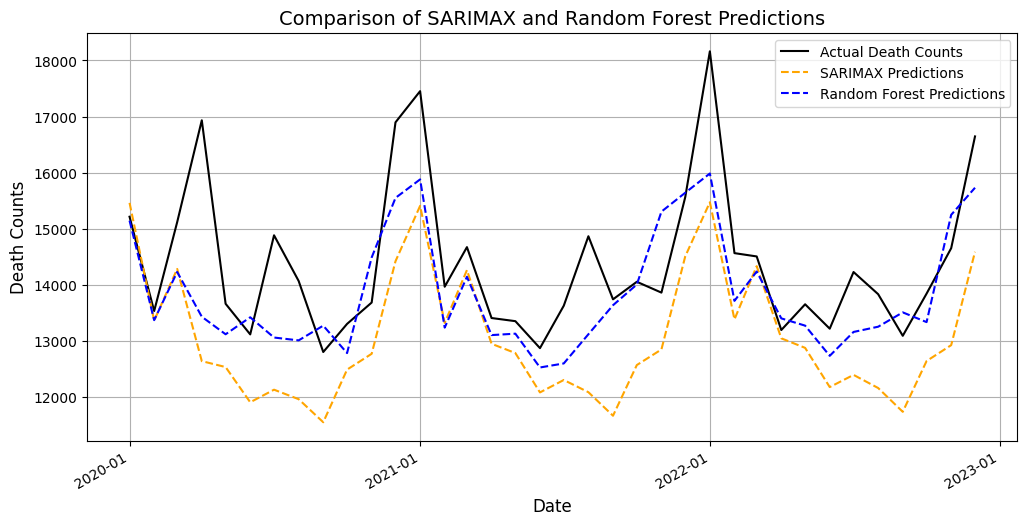

In [51]:
import matplotlib.dates as mdates

# Visualizing predictions for SARIMAX and Random Forest
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(test_data['date'], y_test, label='Actual Death Counts', color='black')

# Plot SARIMAX predictions
plt.plot(test_data['date'], forecast_mean, label='SARIMAX Predictions', color='orange', linestyle='--')

# Plot Random Forest predictions
plt.plot(test_data['date'], y_pred, label='Random Forest Predictions', color='blue', linestyle='--')

# Add labels, title, and legend
plt.title('Comparison of SARIMAX and Random Forest Predictions', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Death Counts', fontsize=12)
plt.legend()

# Format the x-axis for dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  
plt.gca().xaxis.set_major_locator(mdates.YearLocator()) 
plt.gcf().autofmt_xdate()  


plt.grid(True)
plt.show()

## References

1. 2025 ICD-10-CM Codes I00-I99: Diseases of the circulatory system. (n.d.). Retrieved from https://www.icd10data.com/ICD10CM/Codes/I00-I99
